In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Загрузка данных
dataset_path = "Dataset.csv"
variables_description_path = "Variables_description.csv"

# Читаем файлы с указанием кодировки
try:
    df = pd.read_csv(dataset_path, encoding="Windows-1251")
    variables_description = pd.read_csv(variables_description_path)
except Exception as e:
    print("Ошибка загрузки данных:", e)



/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (168,169,170,173,174) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Просмотр общей информации о данных
df.info()
df.head()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72506 entries, 0 to 72505
Columns: 177 entries, total_amount_kzt to DTI3M
dtypes: float64(13), int64(5), object(159)
memory usage: 97.9+ MB


,total_amount_kzt,overdueinstalmentcount_po_subektu,term,GB_flag,was_canceled,GENDER,CLASSIFICATION,RESIDENCY,EDUCATION,MARITALSTATUS,...,AS3M,outstandingamount,overdueamount,instalmentamount,loans,frequency,monetary,recency,rfm_score,DTI3M
0,"413,000 ‚Ѕ",NaN,335,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,10.0,"1,939,663 ‚Ѕ",417 ‚Ѕ,344.0,NaN
1,"417,000 ‚Ѕ",NaN,117,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,1.0,"150,055 ‚Ѕ",340 ‚Ѕ,311.0,NaN
2,"231,000 ‚Ѕ",NaN,366,0,0,515.0,24.0,30.0,658.0,33.0,...,NaN,NaN,NaN,NaN,0.0,2.0,"100,058 ‚Ѕ","4,580 ‚Ѕ",111.0,NaN
3,"1,973,318 ‚Ѕ",0,2192,0,0,516.0,24.0,30.0,NaN,35.0,...,"119,448 ‚Ѕ","1,636,371 ‚Ѕ",0,"154,961 ‚Ѕ",6.0,17.0,"6,356,000 ‚Ѕ",119 ‚Ѕ,455.0,1.297302
4,"500,000 ‚Ѕ",NaN,364,0,0,515.0,24.0,30.0,NaN,34.0,...,NaN,NaN,NaN,NaN,0.0,1.0,"1,500,620 ‚Ѕ","3,311 ‚Ѕ",113.0,NaN


Топ-10 переменных с наибольшим количеством пропусков:
NEGATIVESTATUS       60267
DTI3M                57662
instalmentamount     49784
overdueamount        49784
outstandingamount    49784
recency              48568
monetary             48568
frequency            48568
loans                48568
rfm_score            48568
dtype: int64


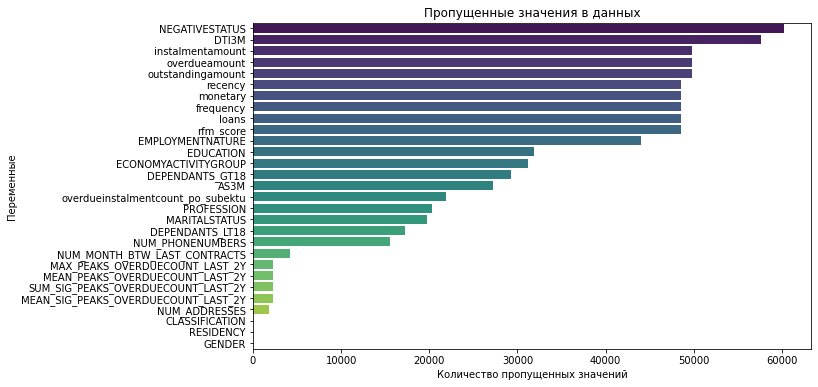

In [4]:
# 1. Анализ пропущенных значений
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print("Топ-10 переменных с наибольшим количеством пропусков:")
print(missing_values.head(10))

# Визуализация пропусков
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_values.values, y=missing_values.index, palette="viridis")
plt.xlabel("Количество пропущенных значений")
plt.ylabel("Переменные")
plt.title("Пропущенные значения в данных")
plt.show()



In [5]:
# 2. Поиск выбросов через IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# Определение границ выбросов
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Подсчет выбросов
outliers = ((df < lower_bound) | (df > upper_bound)).sum()
print("Топ-10 переменных с наибольшим количеством выбросов:")
print(outliers.sort_values(ascending=False).head(10))



Топ-10 переменных с наибольшим количеством выбросов:
EDUCATION         9093
was_canceled      5449
frequency          876
MARITALSTATUS      792
DTI3M              686
GB_flag            570
rfm_score          546
CLASSIFICATION     394
loans              356
NEGATIVESTATUS     229
dtype: int64


In [6]:
# 3. Расчет Information Value (IV) и Weight of Evidence (WoE)
target = 'GB_flag'  # Целевая переменная

# Функция расчета IV и WoE
def calculate_iv_woe(df, feature, target):
    df = df[[feature, target]].copy()
    df = df.dropna()
    
    try:
        df["bin"] = pd.qcut(df[feature], q=10, duplicates='drop')  # Децилирование
    except Exception:
        return None, None  # Если не удалось разбить на бины
    
    grouped = df.groupby("bin")[target].agg(["count", "sum"])
    grouped.columns = ["total", "fraud"]
    grouped["non_fraud"] = grouped["total"] - grouped["fraud"]
    
    grouped["perc_fraud"] = grouped["fraud"] / grouped["fraud"].sum()
    grouped["perc_non_fraud"] = grouped["non_fraud"] / grouped["non_fraud"].sum()
    
    grouped["WoE"] = np.log(grouped["perc_fraud"] / grouped["perc_non_fraud"]).replace({np.inf: 0, -np.inf: 0})
    grouped["IV"] = (grouped["perc_fraud"] - grouped["perc_non_fraud"]) * grouped["WoE"]
    
    return grouped["IV"].sum(), grouped[["WoE"]]

# Вычисление IV и WoE для всех числовых переменных
iv_values = {}
woe_values = {}

num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols.remove(target)  # Исключаем целевую переменную

for col in num_cols:
    iv, woe = calculate_iv_woe(df, col, target)
    if iv is not None:
        iv_values[col] = iv
        woe_values[col] = woe

# Топ-10 переменных по IV
iv_sorted = sorted(iv_values.items(), key=lambda x: x[1], reverse=True)
print("Топ-10 переменных с наибольшим IV:")
print(iv_sorted[:10])



Топ-10 переменных с наибольшим IV:
[('NEGATIVESTATUS', 0.6824865168311329), ('rfm_score', 0.357851167737161), ('term', 0.33760415964237944), ('EDUCATION', 0.2700761152974599), ('ECONOMYACTIVITYGROUP', 0.24827352171190814), ('frequency', 0.23499933997095535), ('DTI3M', 0.18433718811490732), ('PROFESSION', 0.06760656156480475), ('loans', 0.02746203895898917), ('MARITALSTATUS', 0.010777289881146443)]


In [7]:
# Преобразуем нужные столбцы в числовой формат, заменяя ошибки на NaN
cols_to_convert = ['overdueamount', 'outstandingamount', 'instalmentamount', 
                   'NUM_CONTRACTS_FOR', 'NUM_CONTRACTS_STARTED_L6M']

for col in cols_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Ошибки (str) заменяются на NaN

# Генерация новых признаков
df['debt_ratio'] = df['overdueamount'] / (df['outstandingamount'] + 1) # Доля просроченной задолженности.Показывает, насколько большая часть кредита уже просрочена.
#Если этот показатель высокий, вероятность мошенничества может быть выше.
df['installment_ratio'] = df['instalmentamount'] / (df['outstandingamount'] + 1) # Отношение платежа к задолженности. Определяет, насколько ежемесячный платеж соотносится с общей суммой задолженности. Высокие значения могут указывать на заемщиков с низкой кредитной нагрузкой.
df['new_feature_1'] = df['NUM_CONTRACTS_FOR'] * df['NUM_CONTRACTS_STARTED_L6M'] # Пример новой фичи. Если человек оформляет много новых кредитов за последние 6 месяцев, это может быть подозрительным сигналом (например, обналичивание кредитов перед исчезновением).

print("Созданы новые признаки")


Созданы новые признаки


In [8]:
# Сохранение подготовленного датасета
df.to_csv("Processed_dataset.csv", index=False)
print("Файл с обработанными данными сохранен")

Файл с обработанными данными сохранен


In [9]:
pd.read_csv("Processed_dataset.csv")

/opt/tljh/user/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (173,174) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,total_amount_kzt,overdueinstalmentcount_po_subektu,term,GB_flag,was_canceled,GENDER,CLASSIFICATION,RESIDENCY,EDUCATION,MARITALSTATUS,...,instalmentamount,loans,frequency,monetary,recency,rfm_score,DTI3M,debt_ratio,installment_ratio,new_feature_1
0,"413,000 ‚Ѕ",NaN,335,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,0.0,10.0,"1,939,663 ‚Ѕ",417 ‚Ѕ,344.0,NaN,NaN,NaN,0.0
1,"417,000 ‚Ѕ",NaN,117,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,0.0,1.0,"150,055 ‚Ѕ",340 ‚Ѕ,311.0,NaN,NaN,NaN,0.0
2,"231,000 ‚Ѕ",NaN,366,0,0,515.0,24.0,30.0,658.0,33.0,...,NaN,0.0,2.0,"100,058 ‚Ѕ","4,580 ‚Ѕ",111.0,NaN,NaN,NaN,0.0
3,"1,973,318 ‚Ѕ",0,2192,0,0,516.0,24.0,30.0,NaN,35.0,...,NaN,6.0,17.0,"6,356,000 ‚Ѕ",119 ‚Ѕ,455.0,1.297302,NaN,NaN,NaN
4,"500,000 ‚Ѕ",NaN,364,0,0,515.0,24.0,30.0,NaN,34.0,...,NaN,0.0,1.0,"1,500,620 ‚Ѕ","3,311 ‚Ѕ",113.0,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72501,"50,000 ‚Ѕ",0,181,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
72502,"50,000 ‚Ѕ",NaN,181,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
72503,"400,000 ‚Ѕ",0,365,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
72504,"60,000 ‚Ѕ",0,11,0,0,515.0,24.0,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [10]:
# Подсчёт пропусков в процентах
missing_values = df.isnull().sum() / len(df) * 100

# Выбираем только переменные, у которых есть пропуски
missing_values = missing_values[missing_values > 0]

# Топ-10 переменных с наибольшими пропусками
top_10_missing = missing_values.sort_values(ascending=False).head(10)

# Вывод
print("Топ-10 переменных с наибольшим количеством пропусков:")
print(top_10_missing)


Топ-10 переменных с наибольшим количеством пропусков:
installment_ratio    97.051279
debt_ratio           96.917496
outstandingamount    96.910601
instalmentamount     96.736822
NEGATIVESTATUS       83.120018
new_feature_1        82.038728
DTI3M                79.527212
NUM_CONTRACTS_FOR    77.035004
overdueamount        69.409428
monetary             66.984801
dtype: float64
